In [17]:
import psycopg2
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from statistics import median
import datetime

In [2]:
def load_data():
    '''
    loads data
    ret: pd.df
    '''
    db_user, db_password = 'myuser026', '026'
    db_host, db_port = '114.70.14.56', '10051'
    db_name, db_table = 'mydb', 'loans'

    try:
        connection = psycopg2.connect(user=db_user,
                                      password=db_password,
                                      host=db_host,
                                      port=db_port,
                                      database=db_name)
        cursor = connection.cursor()

        # fetch all rows
        query = 'select * from %s' % db_table
        cursor.execute(query, (db_table, id))
        records = cursor.fetchall()

        col_names = [desc[0] for desc in cursor.description]
        cursor.close()

        # create pandas dataframe with data fetched from db
        df = pd.DataFrame(records, columns=col_names)

    except (Exception, psycopg2.Error) as error:
        print('Error fetching data from PostgreSQL table', error)
    finally:
        cursor.close()
        connection.close()

    return df

In [3]:
data = load_data()
data.head()

,id,caseid,activity,ts,goal,apptype,reqamount,action,resource,eventorigin
0,136437,Application_1209992293,A_Submitted,2016-04-24 01:42:08.328,Car,New credit,5000,statechange,User_1,Application
1,136438,Application_1209992293,A_Submitted,2016-04-24 01:42:08.328,Car,New credit,5000,statechange,User_1,Application
2,136439,Application_1209992293,A_Submitted,2016-04-24 01:42:08.328,Car,New credit,5000,statechange,User_1,Application
3,136440,Application_1209992293,A_Submitted,2016-04-24 01:42:08.328,Car,New credit,5000,statechange,User_1,Application
4,136441,Application_1209992293,A_Concept,2016-04-24 01:42:59.435,Car,New credit,5000,statechange,User_1,Application


In [4]:
def filter_event_log(event_log, z):
    '''
    Filter the first z events for cases in the log
    (and delete the events of cases with less than z events)
    :param event_log: a df containing the event log
    :param z: the number of events to filter
    :return: a df containing the filtered event log
    '''
    df = event_log
    # keep only the first z
    df = df.groupby('caseid').head(z)
    # sort by timestamp
    return df.sort_values(by='ts')
    

In [5]:
def display_graph(G, file_name):
    pos = nx.fruchterman_reingold_layout(G)

    # nodes
    nx.draw_networkx_nodes(G, pos,
                           nodelist=G.nodes(),
                           node_color='r',
                           node_size=500,
                           alpha=0.8)

    nx.draw_networkx_edges(G, pos,
                           edgelist=G.edges(),
                           width=2, alpha=0.5, edge_color='r')

    labels = {}
    i = 0
    for node in G.nodes():
        labels[node] = str(node)

    nx.draw_networkx_labels(G, pos, labels, font_size=10)

    plt.axis('off')
    plt.savefig(file_name + ".png")  # save as png
    plt.show()  # display

In [6]:
def get_social_network_handoffs(event_log, z, x):
    '''
    Returns a (networkx) graph containing the
    work handoff social network of an event log
    :param event_log: a df containing the event log
    :param z: the number of events to filter
    :param x: the threshold of handoffs to consider edges
    :return: a social network of handoffs graph
    '''
    event_log = filter_event_log(event_log, z)
    
    caseids = [x for x in event_log['caseid']]
    activities = [x for x in event_log['activity']]
    resources = [x for x in event_log['resource']]
    
    size = len(caseids)
    
    cnt = {}
    
    for i in range(1, size):
        if caseids[i - 1] != caseids[i] or resources[i - 1] == resources[i]:
            continue
        
        c = (resources[i - 1], resources[i])
        if not c in cnt:
            cnt[c] = 0
        cnt[c] += 1
    
    G = nx.DiGraph()
    for c in cnt:
        if cnt[c] >= x:
            a, b = c
            G.add_edge(a, b, weight=cnt[c])
    
    return G

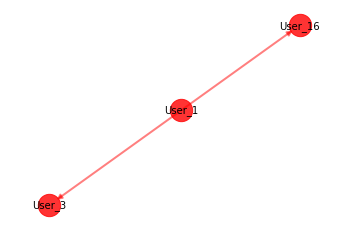

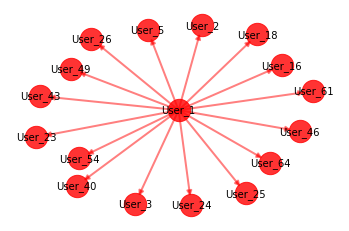

In [7]:
display_graph(get_social_network_handoffs(data, 10, 10), 'snw1')
display_graph(get_social_network_handoffs(data, 5, 5), 'snw2')

In [18]:
def preprocess_event_log(event_log, z):
    '''
    Returns a dataframe containing the event log
    filtered and preprocessed to create items
    :param event_log: a df containing the event log
    :param z: the number of events to filter
    :return: a df containing the filtered and preprocessed log
    '''
    df = filter_event_log(event_log, z)
    caseids = [x for x in df['caseid']]
    tss = [x for x in df['ts']]
    
    dic = {}
    lists = {}
    size = len(caseids)
    for i in range(size):
        caseid = caseids[i]
        ts = tss[i]
        if not caseid in dic:
            dic[caseid] = ts
            lists[caseid] = []
        delta = ts - dic[caseid]
        time_d_ms  = delta / datetime.timedelta(milliseconds=1)
        lists[caseid].append(time_d_ms)
        dic[caseid] = ts
        
    medians = []
    for caseid in lists:
        medians.append({
            'caseid': caseid,
            'median': median(lists[caseid])
        })
    return pd.DataFrame(medians)

In [21]:
prep = preprocess_event_log(data, 50)
prep.head(10)

,caseid,median
0,Application_652823628,0.0
1,Application_828200680,6.0
2,Application_1085880569,9.5
3,Application_1878239836,0.0
4,Application_619403287,0.0
5,Application_1710223761,1.0
6,Application_1529124572,0.0
7,Application_387012864,6.0
8,Application_1120819670,0.0
9,Application_42838382,9.0
